<a href="https://colab.research.google.com/github/rgumi/seminararbeit_src/blob/master/feb_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from scipy.stats import randint, uniform
import datetime as dt
import numpy as np
import pandas as pd 
import json
import urllib.request
pd.options.mode.chained_assignment = None

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, cross_val_score
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost.sklearn import XGBClassifier
from xgboost import XGBRFClassifier

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

In [2]:
mountpath = "/content/drive"
from google.colab import drive
drive.mount(mountpath)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# ['High School', 'University', 'Middle School', 'Professional Training', 
# 'Elementary School', 'Unknown', 'Illiterate']

def group_education(education):
  if education in ['Elementary School']:
    return 'primary'
  if education in ['Middle School', 'High School']:
    return 'secondary'
  if education in ['University', 'Professional Training']:
    return 'tertiary'
  return 'unknown'

# ['Service provider', 'Student', 'Pensioner', 'Administrator', 'Technician',
# 'Blue-collar worker', 'Self-employed', 'Unemployed', 'Manager', 'Housemaid', 'Founder', 'Unknown']

def group_job(job):
  if job in ['Service provider', 'Housemaid']:
    return 'pink-collar worker'
  if job in ['Blue-collar worker']:
    return 'blue-collar worker'
  if job in ['Administrator', 'Manager']:
    return 'white-collar worker'
  if job in ['Self-employed', 'Founder']:
    return 'independent'
  return str.lower(job)

def group_p_conv(pconv):
  if pconv == 'Successful':
    return 1
  if pconv == 'Failed':
    return 2
  return 3

def group_age(age):
  if age < 29:
    return 2
  if age < 59:
    return 3
  return 1

def group_age_q(age):
  if age < 30:
    return 1
  if age < 35:
    return 2
  if age < 42:
    return 3
  if age < 49:
    return 4
  return 5
  
def group_duration(duration):
  if duration == 0:
    return 5
  if duration < 60:
    return 4
  if duration < 300:
    return 3
  if duration < 600:
    return 2
  return 1

def group_martial_status(status):
  if status == 'single':
    return 1
  if status == 'married':
    return 2
  if status == 'divorced':
    return 3
  return 4

In [0]:
df_euribor = pd.read_csv(
    'https://raw.githubusercontent.com/rgumi/seminararbeit_src/master/refined/euribor3m_ref.csv', 
    index_col=['index'], parse_dates=['date'])

df_euribor = df_euribor[(df_euribor['date'].dt.year >= 2007)]

def get_euribor(date):
  for i in range(0, len(df_euribor)):

    if date >= df_euribor['date'].iloc[i]:
      last = df_euribor['value'].iloc[i]
      continue
    return last

In [0]:
df_eurostoxx= pd.read_csv(
    'https://raw.githubusercontent.com/rgumi/seminararbeit_src/master/refined/eurostoxx_ref.csv', 
    index_col=['index'], parse_dates=['date'])

df_eurostoxx = df_eurostoxx[(df_eurostoxx['date'].dt.year >= 2007)]

def get_eurostoxx(date):
  for i in range(0, len(df_eurostoxx)):

    if date >= df_eurostoxx['date'].iloc[i]:
      last = df_eurostoxx['value'].iloc[i]
      continue
    return last

In [0]:
df_fsi= pd.read_csv(
    'https://raw.githubusercontent.com/rgumi/seminararbeit_src/master/refined/fsi_ref.csv', 
    index_col=['index'], parse_dates=['Date'])

df_fsi = df_fsi[(df_fsi['Date'].dt.year >= 2007)]

def get_fsi(date):
  for i in range(0, len(df_fsi)):

    if date >= df_fsi['Date'].iloc[i]:
      # Possible values: [OFR FSI, Credit, Equity valuation, Safe assets, Funding, Volatility]
      last = df_fsi['OFR FSI'].iloc[i]
      continue
    return last

In [0]:
df_cpi = pd.read_csv(
    'https://raw.githubusercontent.com/rgumi/seminararbeit_src/master/refined/cpi_monthly_ref.csv', 
    index_col=['index'], parse_dates=['date'])

df_cpi = df_cpi[(df_cpi['date'].dt.year >= 2007)]

def get_cpi(date):
  for i in range(0, len(df_cpi)):

    if date >= df_cpi['date'].iloc[i]:
      last = df_cpi['value'].iloc[i]
      continue
    return last

In [0]:
df_cci = pd.read_csv(
    'https://raw.githubusercontent.com/rgumi/seminararbeit_src/master/refined/cci_monthly_ref.csv', 
    index_col=['index'], parse_dates=['date'])

df_cci = df_cci[(df_cci['date'].dt.year >= 2007)]

def get_cci(date):
  for i in range(0, len(df_cci)):

    if date >= df_cci['date'].iloc[i]:
      last = df_cci['value'].iloc[i]
      continue
      
    return last

In [0]:
ltz = {}
with urllib.request.urlopen("https://raw.githubusercontent.com/rgumi/seminararbeit_src/master/refined/leitzinsen_eu.json") as url:
    tmp_ltz = json.loads(url.read().decode())
for key in tmp_ltz.keys():
  ltz[dt.datetime.strptime(key, '%d-%m-%Y')] = tmp_ltz[key]
sorted_ltz = {k: ltz[k] for k in sorted(ltz)}

def get_leitzins(date):
  for key, val in sorted_ltz.items():
    if date >= key:
      last = val
      continue
    return last

In [0]:
def lineplot(df, column, title):
  # get the count of each distinct values in series
  value_counts = pd.DataFrame()
  value_counts= df[column].value_counts()
  value_counts_success = df[( df['success'] == 'Yes')].loc[:, column].value_counts()
  # create a plot for the bar graph
  _, axes = plt.subplots(2, 1, figsize=(20, 10))
  sns.set_color_codes("pastel")
  sns.lineplot(value_counts.index, value_counts.values, color="b",
              label="Total", ax=axes[0]) 
  
  sns.set_color_codes("muted")
  sns.lineplot(value_counts_success.index, value_counts_success.values, color="b",
              label="Total", ax=axes[0])
  
  axes[0].legend(ncol=2, loc="upper right", frameon=True)
  axes[0].set_title(title)

  sns.boxplot(dataset[column], ax=axes[1],
              flierprops = dict(markerfacecolor = '0.50', markersize = 2))

In [0]:
def barboxplot(df, column, title):
  '''
    creates a barplot for the given data in df[column]
    -> shows the distribution the successrate of the given data
    createa s boxplot for the given data in df[column]
  '''
  # get the count of each distinct values in series
  value_counts = pd.DataFrame()
  value_counts= df[column].value_counts()
  value_counts_success = df[( df['success'] == 'Yes')].loc[:, column].value_counts()
  # create a plot for the bar graph
  _, axes = plt.subplots(2, 1, figsize=(20, 10))

  sns.set_color_codes("pastel")
  sns.barplot(value_counts.index, value_counts.values, color="b",
              label="Total", ax=axes[0])

  sns.set_color_codes("muted")
  sns.barplot(value_counts_success.index, value_counts_success.values,
              color="b", label="Successful", ax=axes[0])
  

  axes[0].legend(ncol=2, loc="upper right", frameon=True)
  axes[0].set_title(title)

  sns.boxplot(dataset[column], ax=axes[1],
              flierprops = dict(markerfacecolor = '0.50', markersize = 2))
  return 

def barplot(df, column, title):
  '''
    creates a barplot for the given data in df[column]
    -> shows the distribution the successrate of the given data
  '''
  _, axes = plt.subplots(1, 1, figsize=(20, 10))
  # get the count of each distinct values in series
  value_counts = pd.DataFrame()
  value_counts= df.loc[:, column].value_counts()
  value_counts_success = df[( df['success'] == 'Yes')].loc[:, column].value_counts()
  # create a plot for the bar graph


  sns.set_color_codes("pastel")
  sns.barplot(value_counts.index, value_counts.values, color="b",
              label="Total", ax=axes)

  sns.set_color_codes("muted")
  sns.barplot(value_counts_success.index, value_counts_success.values,
              color="b", label="Successful", ax=axes)
  

  axes.legend(ncol=2, loc="upper right", frameon=True)
  axes.set_title(title)

In [0]:
dataset = pd.read_csv(
    'https://raw.githubusercontent.com/saschaschworm/big-data-and-data-science/master/datasets/prediction-challenge/dataset.csv', 
    index_col='identifier', parse_dates=['date'])

dataset.insert(len(dataset.columns) -1, "weekday", dataset.date.dt.weekday)
dataset.insert(len(dataset.columns) -1, "day", dataset.date.dt.day)
dataset.insert(len(dataset.columns) -1, "month", dataset.date.dt.month)
dataset.insert(len(dataset.columns) -1, "year", dataset.date.dt.year)
dataset.insert(len(dataset.columns) -1, "quarter", dataset.date.dt.quarter)

dataset.insert(len(dataset.columns)-1, "leitzins", dataset['date'].apply(get_leitzins))
dataset.insert(len(dataset.columns)-1, "euribor", dataset['date'].apply(get_euribor))
dataset.insert(len(dataset.columns)-1, "cci", dataset['date'].apply(get_cci))
dataset.insert(len(dataset.columns)-1, "cpi", dataset['date'].apply(get_cpi))
dataset.insert(len(dataset.columns)-1, "fsi", dataset['date'].apply(get_fsi))
dataset.insert(len(dataset.columns)-1, "eurostoxx", dataset['date'].apply(get_eurostoxx))

dataset = dataset.drop('date', axis=1)
dataset.columns


In [0]:
barboxplot(dataset, 'age', 'Age Distribution')
print(dataset['age'].quantile(.99))
plt.savefig(mountpath + '/My Drive/seminararbeit/images/age.png')

11.0


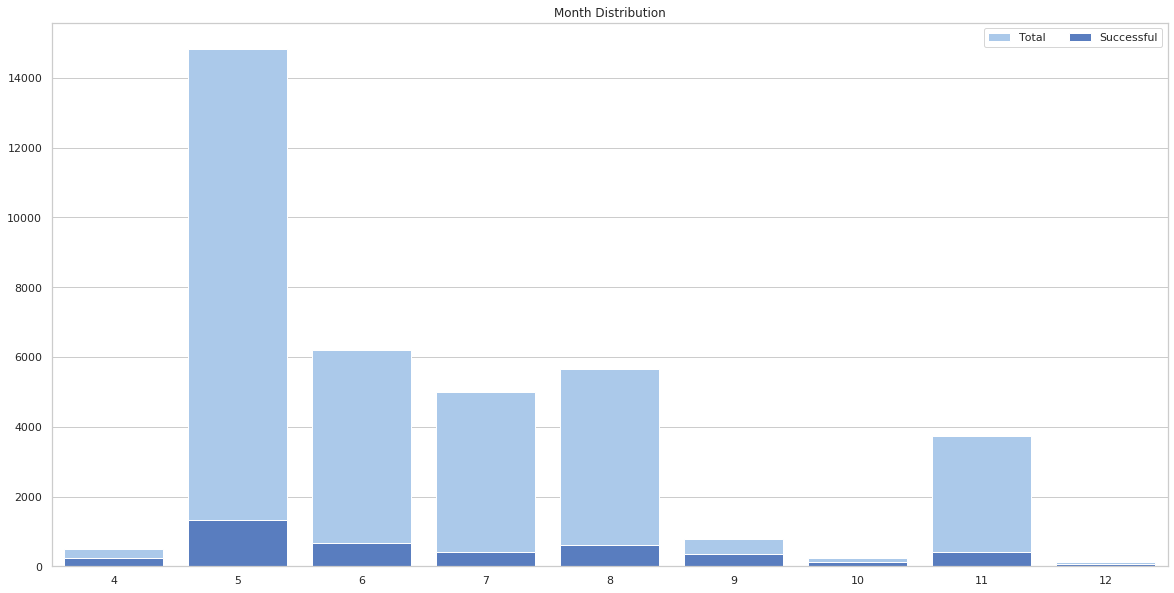

In [146]:
barplot(dataset, 'month', 'Month Distribution')
print(dataset['month'].quantile(.99))
plt.savefig(mountpath + '/My Drive/seminararbeit/images/month.png')

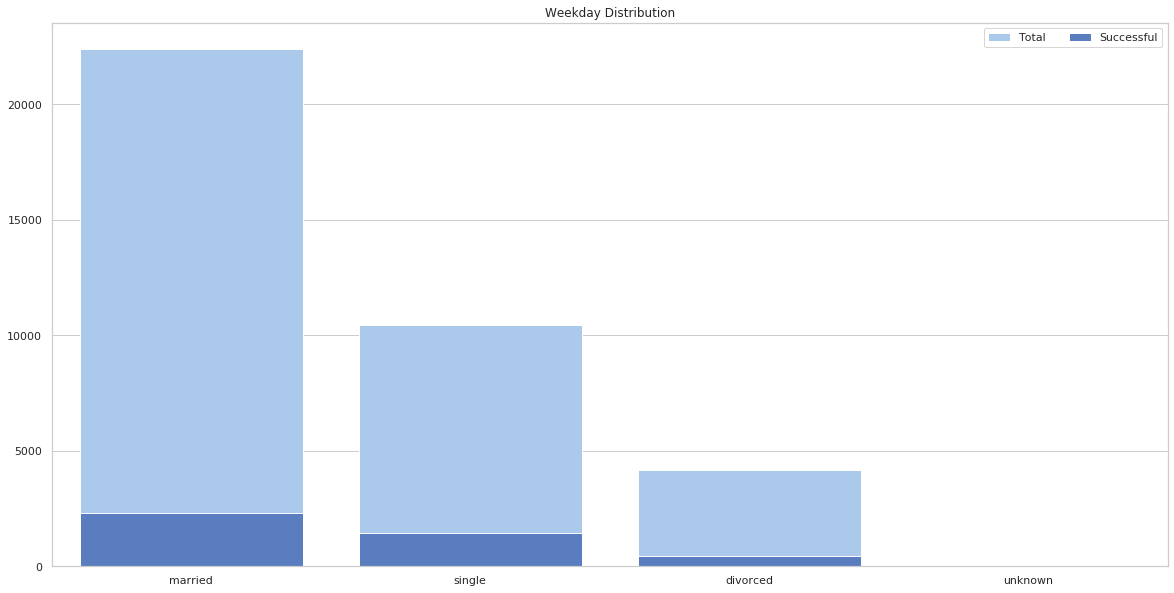

In [144]:
barplot(dataset, 'marital_status', 'Weekday Distribution')
plt.savefig(mountpath + '/My Drive/seminararbeit/images/maritalstatus.png')

In [0]:
X, y = dataset[['month', 'education', 'job', 'age', 'previous_conversion', 'n_contacts_before',
       'days_since_last_contact', 'n_contacts_campaign', 'marital_status', 'credit_default',
       'duration', 'housing_loan', 'personal_loan',
       'euribor'
       ]], dataset['success']

y = y.apply(lambda x: 1 if x == "Yes" else 0)

#X = X[(X['job'] != 'Unknown')]

#X['education'] = X['education'].apply(group_education)
#X['job'] = X['job'].apply(group_job)
X['previous_conversion'] = X['previous_conversion'].apply(group_p_conv)
#X['marital_status'] = X['marital_status'].apply(group_martial_status)
# X['age'] = X['age'].apply(group_age_q) # group_age_q == quantile
# X['duration'] = X['duration'].apply(group_duration)

for item in ['education', 'job', 'previous_conversion',
             'credit_default', 'housing_loan', 
             'education', 'marital_status', 'personal_loan']:
  try:
    encoded = pd.get_dummies(X[item], prefix=item)
    X.drop(item, axis=1, inplace=True)
    X = X.join(encoded)
  except:
    continue

scaler = MinMaxScaler()
numeric_values = ['n_contacts_campaign', 'n_contacts_before', 'duration', 
                  'days_since_last_contact', 'age',
                  'euribor'
                  ]

X[numeric_values] = scaler.fit_transform(X[numeric_values])

# Model Comparison

The objective of this model is to predict a binary classification. Therefore only models that support binary classificiation are compared. The models are:
1. Logistic Regression (`sklearn.linear_model SGDClassifier`)
2. Decision Tree: Random Forests(`sklearn.ensemble RandomForestClassifier` & `xgboost XGBRFClassifier`)

In [0]:
all_results = []
results = {}
def evaluate_model(model):
  model_name = f'Model: {str(model).split("(")[0]}'
  print(model_name)
  res_cv = cross_validate(model, X, y, scoring=['f1'], cv=10, return_train_score=True)
  res_f1_tr = np.mean(res_cv['train_f1']) * 100
  res_f1_te = np.mean(res_cv['test_f1']) * 100
  model_result = f'{res_f1_tr:.2f}%/{res_f1_te:.2f}%'
  results[model_name] = model_result
  print(f'Average F1 on Training and Test Set: {res_f1_tr:.2f}%/{res_f1_te:.2f}%\n')

In [0]:
def evaluate_model_splitted(model):
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1909)
  model.fit(X_train, y_train)
  model_pred = model.predict(X_test)
  print(classification_report(model_pred, y_test))
  print(confusion_matrix(y_test, model_pred))
  print('---\n') 

In [122]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier


evaluate_model(SGDClassifier())
evaluate_model_splitted(SGDClassifier())

evaluate_model(RandomForestClassifier())
evaluate_model_splitted(RandomForestClassifier())

evaluate_model(XGBClassifier())
evaluate_model_splitted(XGBClassifier())

evaluate_model(XGBRFClassifier())
evaluate_model_splitted((XGBRFClassifier()))

all_results.append(results)
print(all_results)

Model: SGDClassifier
Average F1 on Training and Test Set: 43.21%/43.11%

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     13447
           1       0.48      0.59      0.53      1381

    accuracy                           0.90     14828
   macro avg       0.72      0.76      0.74     14828
weighted avg       0.91      0.90      0.91     14828

[[12574   565]
 [  873   816]]
---

Model: RandomForestClassifier
Average F1 on Training and Test Set: 99.99%/51.95%

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     13698
           1       0.43      0.64      0.52      1130

    accuracy                           0.91     14828
   macro avg       0.70      0.79      0.73     14828
weighted avg       0.93      0.91      0.92     14828

[[12735   404]
 [  963   726]]
---

Model: XGBClassifier
Average F1 on Training and Test Set: 58.73%/56.79%

              precision    recall  f1-score   

In [0]:
print(all_results[0]) # basic
print(all_results[1]) # leitzins
print(all_results[2]) # euribor3m
print(all_results[3]) # leitzins + euribor3m

# Model Selection

Based on the previous evaluation the models chosen to be futher evaluated are:
1. XGBClassfier
2. XGBRFClassifier

# Hyperparameter optimization

In [0]:
custom_scorer = make_scorer(f1_score)

# randomized hyperparameter optimization
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
def optimization(model):
  print(f'Model: {str(model)}')
  ## default is 3
  n_estimators = randint(2, 20)
  ## default is 100
  max_depth = randint(80, 120)
  ## default is 0.1 and 1 respectively
  learning_rate = uniform()

  # Sampling
  ## default is 1
  colsample_bytree = uniform()
  ## default is 1
  colsample_bylevel = uniform()
  ## default is 1
  colsample_bynode = uniform()

  # default is 1
  min_child_weight = uniform()


  gamma = uniform()
  base_score = uniform()
  subsample = uniform()

  # optimization parameters
  param_distributions = {#'model__n_estimators': n_estimators,
                         #'model__max_depth': max_depth,
                         #'model__learning_rate': learning_rate,
                         #'model__gamma': gamma,
                         #'model__min_child_weight': min_child_weight,
                         #'model__base_score': base_score,
                         'model__subsample': subsample,
                         'model__colsample_bylevel': colsample_bylevel,
                         'model__colsample_bytree': colsample_bytree,
                         'model__colsample_bynode': colsample_bynode,
                        }
                        
  rs = RandomizedSearchCV(model, param_distributions=param_distributions, n_iter=5,
                        scoring=custom_scorer, n_jobs=-1, cv=10, random_state=1909)
  
  rs = rs.fit(X, y)
  return rs.best_params_

In [0]:
from xgboost import XGBClassifier, XGBRFClassifier

hyperparams = {'seed': 1909,
                'nthread': -1,
                'booster': 'gbtree',
                'objective': 'binary:logistic',
                'silent': True,
                'reg_lambda': 1,
                'missing': None,
                'max_delta_step': 0,
                'n_estimators': 94,
                'max_deph': 11,
                'gamma': 0,
                'learning_rate': 0.3,
                'base_score': 0.5,
                'min_child_weight': 1,
                'scale_pos_weight': 9,
                'subsample': 1,
                'colsample_bylevel': 1,
                'colsample_bytree': 1,
                'colsample_bynode': 1,
                'reg_lambda': 1,
              }

xg_classifier = XGBClassifier(**hyperparams)
#print(f'parameters (xg_classifier):\n{xg_classifier}')
xg_classifier_params = optimization(xg_classifier)
print(xg_classifier_params)

hyperparams = {'seed': 1909,
                'nthread': -1,
                'objective': 'binary:logistic',
                'silent': True,
                'reg_lambda': 1,
                'missing': None,
                'max_delta_step': 0,
                'n_estimators': 94,
                'max_deph': 11,
                'gamma': 0,
                'learning_rate': 1,
                'base_score': 0.5,
                'min_child_weight': 1,
                'scale_pos_weight': 9,
                'subsample': 1,
                'colsample_bylevel': 1,
                'colsample_bytree': 1,
                'colsample_bynode': 1,
                'reg_lambda': 1,
              }

xg_rf_classifier = XGBRFClassifier(**hyperparams)
#print(f'parameters (xg_rf_classifier):\n{xg_rf_classifier}')
xg_rf_classifier_params = optimization(xg_rf_classifier)
print(xg_rf_classifier_params)

# Evaluating Model with Optimized Parameter

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1909)

hyperparams = {'seed': 1909,
                'nthread': -1,
                'booster': 'gbtree',
                'objective': 'binary:logistic',
                'silent': True,
                'reg_lambda': 1,
                'missing': None,
                'max_delta_step': 0,
                'n_estimators': 120,
                'max_deph': 3,
                'gamma': 0,
                'learning_rate': 0.05,
                'base_score': 0.5,
                'min_child_weight': 1,
                'scale_pos_weight': 9,
                'subsample': 1,
                'colsample_bylevel': 1,
                'colsample_bytree': 1,
                'colsample_bynode': 1,
                'reg_lambda': 1,
              }

xg_classifier = XGBClassifier(**hyperparams)
evaluate_model(xg_classifier)
evaluate_model_splitted(xg_classifier)

Model: XGBClassifier

Average F1 on Training and Test Set: 52.28%/51.53%

              precision    recall  f1-score   support

           0       0.83      0.97      0.90     11247
           1       0.83      0.39      0.53      3581

    accuracy                           0.83     14828
   macro avg       0.83      0.68      0.71     14828
weighted avg       0.83      0.83      0.81     14828

[[10956  2183]
 [  291  1398]]
---



In [93]:
hyperparams = {'random_state': 1909,
                'nthread': -1,
                'objective': 'binary:logistic',
                'silent': True,
                'reg_lambda': 1,
                'missing': None,
                'max_delta_step': 0,
                'n_estimators': 96,
                'max_deph': 11,
                'gamma': 0,
                'learning_rate': 0.05,
                'base_score': 0.5,
                'min_child_weight': 1,
                'scale_pos_weight': 1,
                'subsample': 1,
                'colsample_bylevel': 1,
                'colsample_bytree': 1,
                'colsample_bynode': 1,
                'reg_lambda': 1,
              }

xg_rf_classifier = XGBRFClassifier(**hyperparams)
print(xg_rf_classifier)
evaluate_model(xg_rf_classifier)
evaluate_model_splitted(xg_rf_classifier)

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=1,
                colsample_bytree=1, gamma=0, learning_rate=0.05,
                max_delta_step=0, max_deph=11, max_depth=3, min_child_weight=1,
                missing=None, n_estimators=96, n_jobs=1, nthread=-1,
                objective='binary:logistic', random_state=1909, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
                subsample=1, verbosity=1)
Model: XGBRFClassifier

Average F1 on Training and Test Set: 47.38%/47.23%

              precision    recall  f1-score   support

           0       0.97      0.92      0.95     13831
           1       0.37      0.63      0.47       997

    accuracy                           0.90     14828
   macro avg       0.67      0.78      0.71     14828
weighted avg       0.93      0.90      0.91     14828

[[12772   367]
 [ 1059   630]]
---

